In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
count = 1200
count_test = 200

train_X = MNIST_train.data.numpy()[:count]
train_Y = MNIST_train.targets.numpy()[:count]
test_X = MNIST_test.data.numpy()[:count_test]
test_Y = MNIST_test.targets.numpy()[:count_test]

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_Y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_Y.shape))

X_train: (1200, 28, 28)
Y_train: (1200,)
X_test:  (200, 28, 28)
Y_test:  (200,)


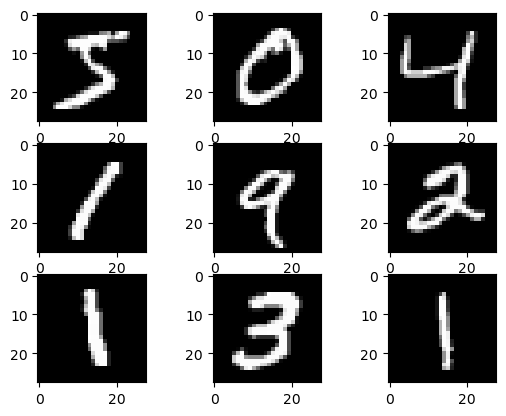

In [4]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

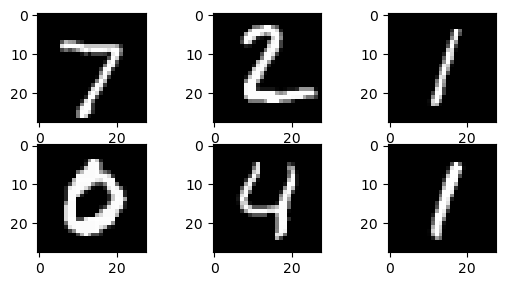

In [5]:
for i in range(6):
    plt.subplot(331 + i)
    plt.imshow(test_X[i], cmap=plt.get_cmap('gray'))

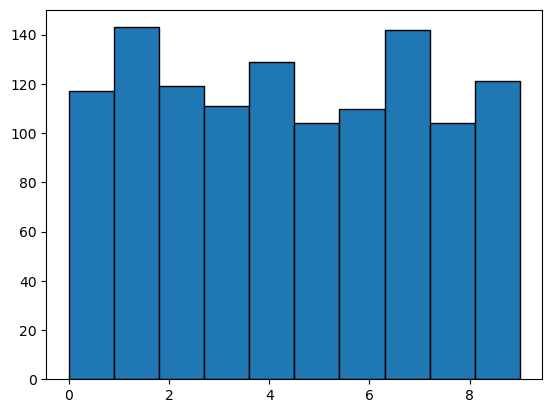

In [6]:
plt.hist(train_Y, bins=10, edgecolor='black')
plt.show()

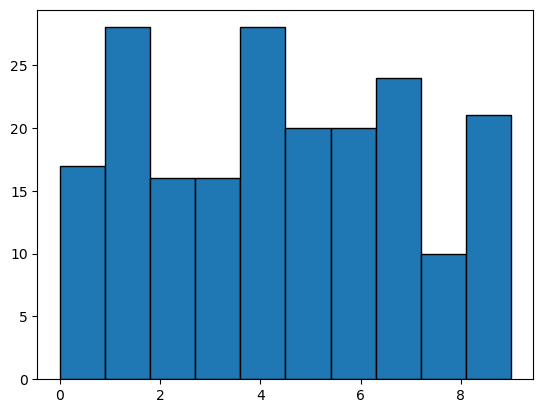

In [7]:
plt.hist(test_Y, bins=10, edgecolor='black')
plt.show()

In [8]:
train_X = np.array(list(map(lambda x: x.flatten() / 256, train_X)))

train_Y = np.array([np.array([int(i == x) for i in range(10)]) for x in train_Y])
test_X = np.array(list(map(lambda x: x.flatten() / 256, test_X)))
test_Y = np.array([np.array([int(i == x) for i in range(10)]) for x in test_Y])

In [9]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_Y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_Y.shape))

X_train: (1200, 784)
Y_train: (1200, 10)
X_test:  (200, 784)
Y_test:  (200, 10)


In [10]:
def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x) / (np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x): return 1/(1+np.exp(-x))

def sigmoid_derivative(x): return sigmoid(x)*(1-sigmoid(x))

def cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    return -np.mean(y_true * np.log(y_pred))

def cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
    res = y_pred - y_true
    return res / np.linalg.norm(res)


In [11]:
class LinearLayer:
    def __init__(self, input_size, output_size, optimizer, model):
        self.adam_m = None
        self.adam_v = None
        self.adam_t = None
        self.inputs = None
        self.dropout_mask = None
        self.weights = np.random.rand(input_size + 1, output_size) - 0.5
        self.optimizer = optimizer
        self.model = model

    def forward(self, inputs, train=True):
        self.dropout_mask = np.random.choice(a=[0, 1], size=self.weights.shape, p=[self.model.d_chance, 1 - self.model.d_chance])
        inputs = np.append([1], inputs)

        if train:
            self.inputs = inputs
        return inputs @ (self.weights*self.dropout_mask)

    def calculate(self):
        return self.model.calculate(self, self.inputs[:-1])

    def backward(self, grad, train=True):
        if not train:
            return (grad @ self.weights.T)[1:]
        accum_grad = (grad @ (self.weights * self.dropout_mask).T)[1:]
        step_grad = np.outer(self.inputs, grad)
        step_grad *= self.dropout_mask
        if np.linalg.norm(step_grad) != 0:
            step_grad /= np.linalg.norm(step_grad)
        step = None
        match self.optimizer:
            case 0:
                # SGD
                step = step_grad
            case 1:
                # Adam
                if self.adam_t is None:
                    self.adam_t = 0
                    self.adam_m = np.zeros(self.weights.shape)
                    self.adam_v = np.zeros(self.weights.shape)
                self.adam_t += 1
                self.adam_m = self.model.beta1 * self.adam_m + (1 - self.model.beta1) * step_grad
                self.adam_v = self.model.beta2 * self.adam_v + (1 - self.model.beta2) * step_grad**2
                m = self.adam_m / (1 - self.model.beta1**self.adam_t)
                v = self.adam_v / (1 - self.model.beta2**self.adam_t)
                step = self.model.lr * m / np.sqrt(v + 10e-8)


        self.weights -= step

        if self.model.alpha is not None:
            l2_reg = self.model.alpha * self.model.lr * self.dropout_mask
            self.weights -= l2_reg
        return accum_grad


In [12]:
class ActivationLayer:
    def __init__(self, activation, activation_derivative):
        self.inputs = None
        self.activation = activation
        self.activation_derivative = activation_derivative
    def forward(self, inputs, train=True):
        self.inputs = inputs
        return self.activation(inputs)
    def backward(self, grad, train=True):
        return grad * self.activation_derivative(self.inputs)


In [13]:
class Perceptron:
    def __init__(self, input_size, sizes, loss, loss_derivative, optimizer, lr, d_chance, beta1, beta2, alpha):
        self.last_true = None
        self.layers = []
        self.beta1 = beta1
        self.beta2 = beta2
        self.d_chance = d_chance
        self.alpha = alpha
        prev_size = input_size
        for size in sizes:
            self.layers.append(LinearLayer(prev_size, size, optimizer, self))
            self.layers.append(ActivationLayer(sigmoid, sigmoid_derivative))
            prev_size = size
        self.layers.append(LinearLayer(prev_size, 10, optimizer, self))
        self.layers.append(ActivationLayer(softmax, lambda x: softmax(x) * (1 - softmax(x))))
        self.loss = loss
        self.loss_derivative = loss_derivative
        self.lr = lr

    def forward(self, inputs, train=True):
        result = inputs
        for layer in self.layers:
            result = layer.forward(result, train)
        return result

    def backward(self, y_true, y_pred):
        grad = self.loss_derivative(y_true, y_pred)
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, inputs, y_true):
        self.last_true = y_true
        y_pred = self.forward(inputs, True)
        loss = self.loss(y_true, y_pred)
        self.backward(y_true, y_pred)
        return y_pred, loss

    def calculate(self, layer, inputs):
        place = self.layers.index(layer)
        result = inputs
        for layer in self.layers[place:]:
            result = layer.forward(result, False)
        return self.loss(self.last_true, result)

    def nag_helper(self, layer, inputs):
        place = self.layers.index(layer)
        result = inputs
        for layer in self.layers[place:]:
            result = layer.forward(result, False)
        grad = self.loss_derivative(self.last_true, result)
        for layer in self.layers[place + 1:][::-1]:
            grad = layer.backward(grad, False)
        return grad

    def train(self, epochs):
        accuracy = []
        loss_arr = []
        for _ in tqdm(range(epochs)):
            running_accuracy = 0
            running_loss = 0
            for inputs, y_true in zip(train_X, train_Y):
                y_pred, loss = self.fit(inputs, y_true)
                pred = np.argmax(y_pred)
                running_loss += loss
                running_accuracy += (np.argmax(y_true) == pred)
            accuracy.append(running_accuracy / len(train_X))
            loss_arr.append(running_loss / len(train_X))
        return accuracy, loss_arr

    def validate(self):
        running_accuracy = 0
        running_loss = 0
        for inputs, y_true in zip(test_X, test_Y):
            y_pred = self.forward(inputs, False)
            loss = self.loss(y_true, y_pred)
            pred = np.argmax(y_pred)
            running_loss += loss
            running_accuracy += (np.argmax(y_true) == pred)
        return running_loss / len(test_X), running_accuracy / len(test_X)

In [14]:
def experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, loss, loss_der, d_chance, beta1, beta2, alpha):
    perceptron = Perceptron(28 * 28, [layer_neurons for _ in range(layer_count)], loss, loss_der, optimizer, learning_rate, d_chance, beta1, beta2, alpha)

    accuracy, loss = perceptron.train(epochs)


    plt.plot(np.arange(len(accuracy)), accuracy)
    plt.title("Accuracy")
    plt.show()
    plt.plot(np.arange(len(loss)), loss)
    plt.title("Loss")
    plt.show()

    print(perceptron.validate())

100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


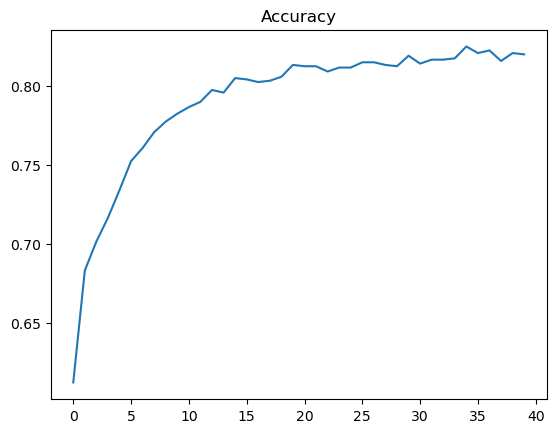

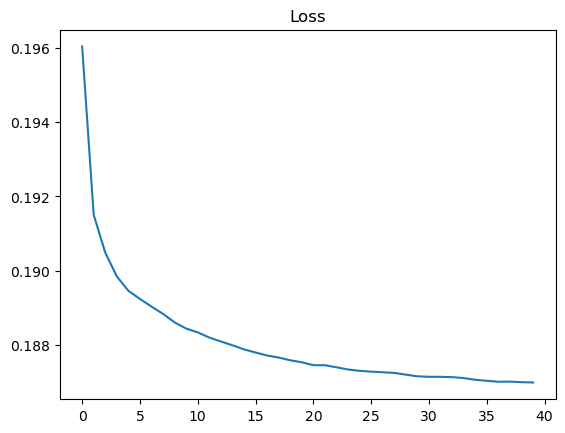

(0.1898377048520271, 0.735)


In [15]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0
alpha = None

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance,
           beta1, beta2, alpha)

100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


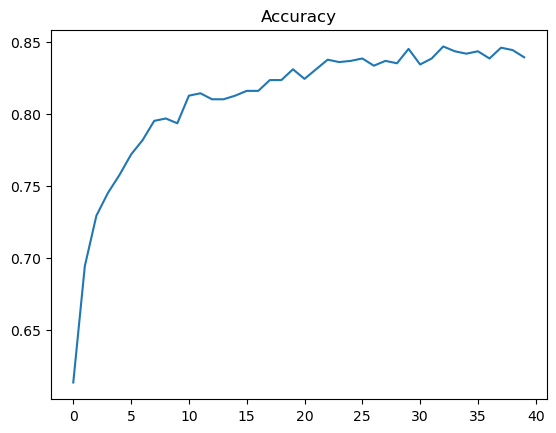

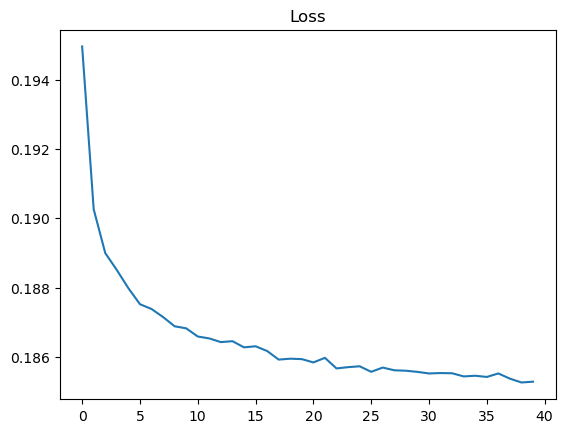

(0.1871590263350513, 0.795)


In [16]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0.05
alpha = None

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance,
           beta1, beta2, alpha)

100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


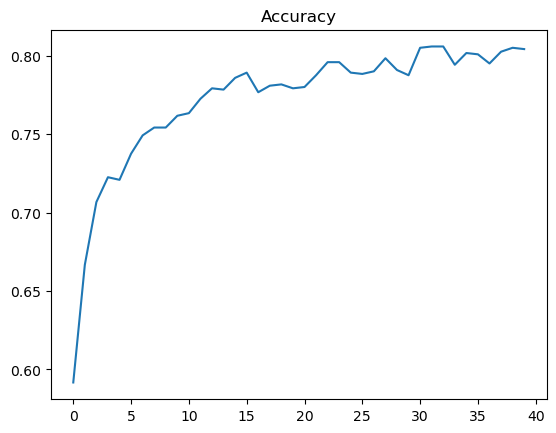

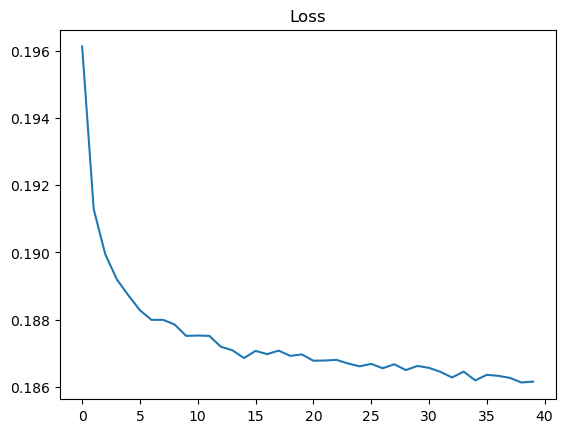

(0.1879428074179173, 0.75)


In [17]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0.1
alpha = None

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)

100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


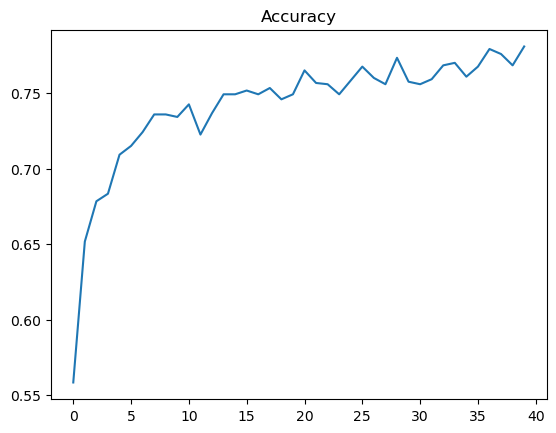

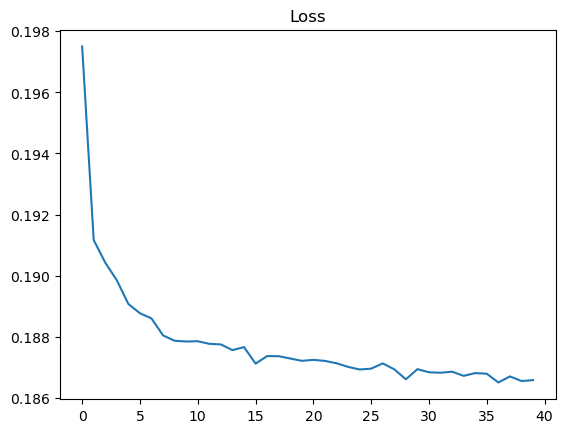

(0.18827353563907118, 0.72)


In [18]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0.2
alpha = None

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)

100%|██████████| 40/40 [01:00<00:00,  1.52s/it]


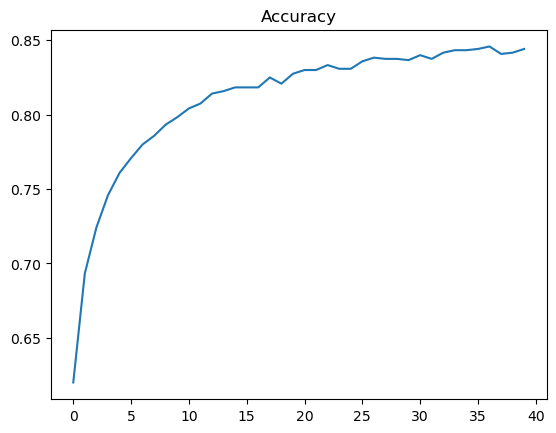

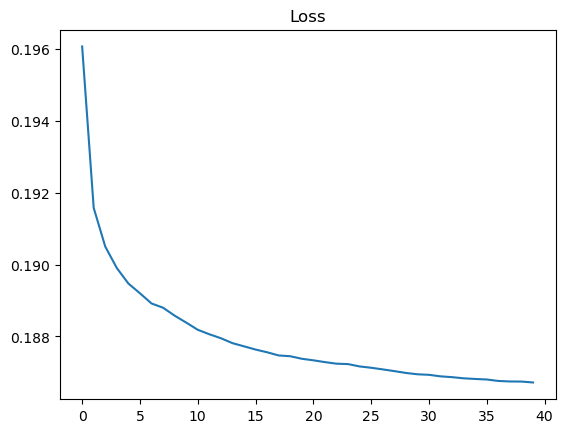

(0.18988968123290512, 0.74)


In [20]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0
alpha = 5e-4

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)

100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


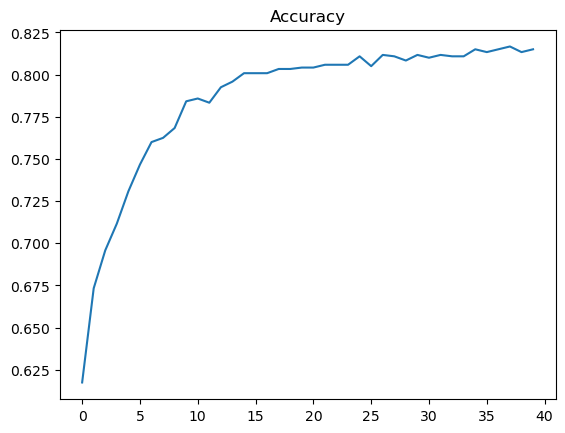

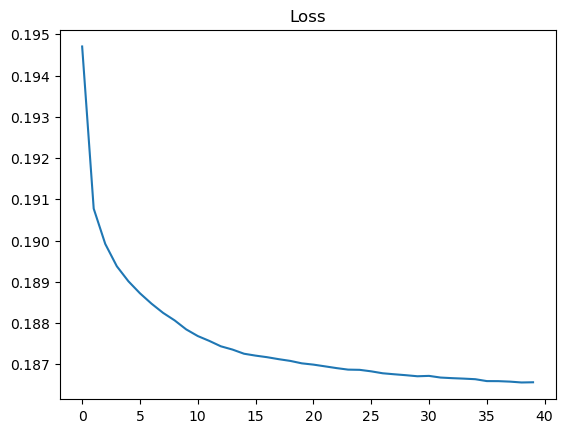

(0.18922225621155234, 0.72)


In [21]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0
alpha = 5e-3

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)

 20%|██        | 8/40 [00:11<00:46,  1.45s/it]/tmp/ipykernel_15047/582496314.py:14: RuntimeWarning: overflow encountered in exp
  def sigmoid(x): return 1/(1+np.exp(-x))
100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


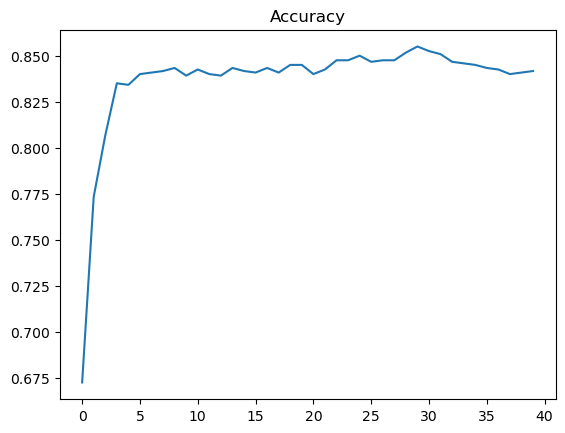

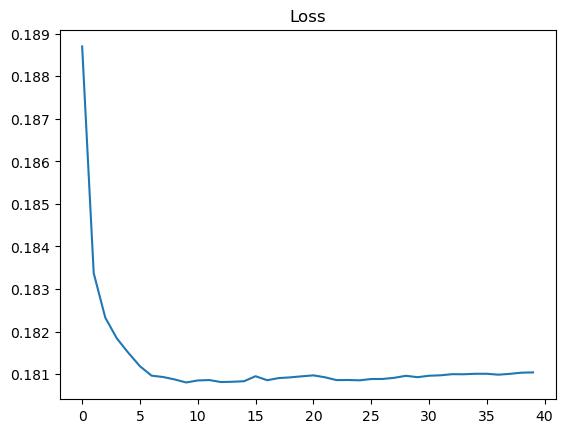

(0.1861926434691016, 0.765)


In [22]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0
alpha = 5e-2

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)

100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


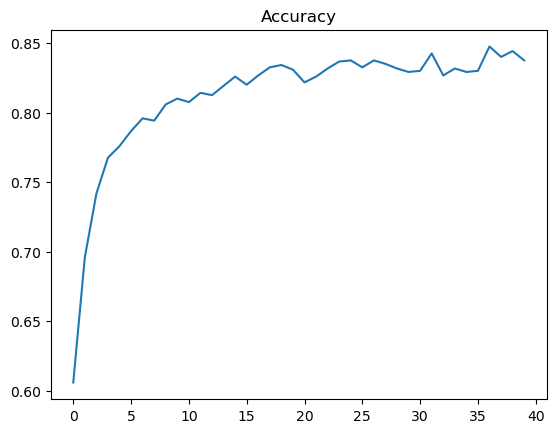

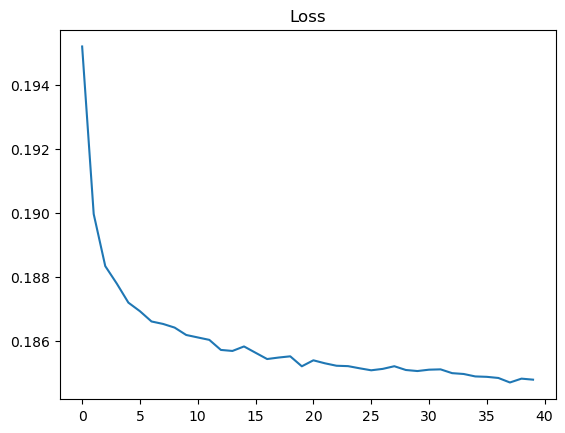

(0.18751345422396612, 0.745)


In [23]:
learning_rate = 0.0065
layer_count = 1
layer_neurons = 64
epochs = 40
optimizer = 0
beta1 = 0.9
beta2 = 0.999
d_chance = 0.05
alpha = 5e-4

experiment(learning_rate, layer_count, layer_neurons, epochs, optimizer, cross_entropy, cross_entropy_derivative, d_chance, beta1, beta2, alpha)